In [14]:
import pandas as pd
import numpy as np
df = pd.read_csv('NCEIclimaterecords.csv')

In [15]:
df.head()

ID        Date Element  Data_Value
0  USW00094889  2014-11-12    TMAX          22
1  USC00208972  2009-04-29    TMIN          56
2  USC00200032  2008-05-26    TMAX         278
3  USC00205563  2005-11-11    TMAX         139
4  USC00200230  2014-02-27    TMAX        -106

## Preprocessing Data

In [16]:
# Converting temperture values to degress Celcius
df['Data_Value'] = df['Data_Value']/10

In [17]:
# Splitting df to max and min temperatures

df_TMAX = df[df['Element'] == 'TMAX']
df_TMIN = df[df['Element'] == 'TMIN']


In [18]:
# create a DataFrame of maximum temperature sorted by date
df_DateMAX = df_TMAX.groupby("Date").agg({"Data_Value":np.max})
df_DateMAX = df_DateMAX.reset_index()

# create a DataFrame of minimum temperatures sorted by date
df_DateMIN = df_TMIN.groupby("Date").agg({"Data_Value":np.min})
df_DateMIN= df_DateMIN.reset_index()


In [19]:
#Remove Leap Years

maskMAX = df_DateMAX["Date"].str.contains('-02-29')
df_DateMAX = df_DateMAX[~maskMAX]

maskMIN = df_DateMIN["Date"].str.contains('-02-29')
df_DateMIN = df_DateMAX[~maskMIN]


In [20]:
# Sperates out data for 2015 vs 2005-2014 to create 4 dataframes

maskMAX2015 = df_DateMAX["Date"].str.contains('2015')
df_DateMAX_2015 = df_DateMAX[maskMAX2015] # Max tempetures for 2015

maskMIN2015 = df_DateMIN["Date"].str.contains('2015')
df_DateMIN_2015 = df_DateMIN[maskMIN2015] # Min tempetures for 2015

df_DateMAX_05_14 = df_DateMIN[~maskMAX2015] # Max temperatures for 2005-2014

df_DateMIN_05_14 = df_DateMIN[~maskMIN2015] # Min temperatures for 2005-2014

In [21]:
# Calculate the minimum and maximum values for the day of the year for 2005 through 2014

# Extract day and month from the 'Date' column in order to group by day of year
df_DateMAX_05_14["Day & Month"] = df_DateMAX_05_14['Date'].str[5:]                                 
df_DateMIN_05_14["Day & Month"] = df_DateMIN_05_14['Date'].str[5:]

# Group by day and month and calculate the maximum and minimum values
df_DateMAX_05_14 = df_DateMAX_05_14.groupby("Day & Month").agg({"Data_Value":np.max})
df_DateMIN_05_14 = df_DateMIN_05_14.groupby("Day & Month").agg({"Data_Value":np.min})


In [22]:
# Calculate the minimum and maximum values for the year 2015

# Extract day and month from the 'Date' column in order to group by day of year
df_DateMAX_2015["Date"] = df_DateMAX_2015['Date'].str[5:]                                 
df_DateMIN_2015["Date"] = df_DateMIN_2015['Date'].str[5:]

# Set 'Date' column as index
df_DateMAX_2015 = df_DateMAX_2015.set_index(['Date'])
df_DateMIN_2015 = df_DateMIN_2015.set_index(['Date'])

In [23]:
# Insert the maximum and minimum temperature values for 2005-2014 into the dataframe for 2015

df_DateMAX_2015.insert(1, "2005-2014", df_DateMAX_05_14["Data_Value"])
df_DateMIN_2015.insert(1, "2005-2014", df_DateMIN_05_14["Data_Value"])

In [24]:
# Filter the dataframe to select maximum and minimum temperature records in 2015 that exceed those of the years 2005-2014

df_DateMAX_2015_Exceed =  df_DateMAX_2015[df_DateMAX_2015['Data_Value']>df_DateMAX_2015["2005-2014"]]
df_DateMIN_2015_Exceed =  df_DateMIN_2015[df_DateMIN_2015['Data_Value']<df_DateMIN_2015["2005-2014"]]

In [25]:
# Putting each value back into datetime to allow convertion to months for formatting (The use of 2024 is arbitrary)

df_DateMAX_05_14.index = pd.to_datetime('2024-' + df_DateMAX_05_14.index, format='%Y-%m-%d')
df_DateMIN_05_14.index = pd.to_datetime('2024-' + df_DateMIN_05_14.index, format='%Y-%m-%d')
df_DateMAX_2015_Exceed.index = pd.to_datetime('2024-' + df_DateMAX_2015_Exceed.index, format='%Y-%m-%d')
df_DateMIN_2015_Exceed.index = pd.to_datetime('2024-' + df_DateMIN_2015_Exceed.index, format='%Y-%m-%d')

## Visualisation

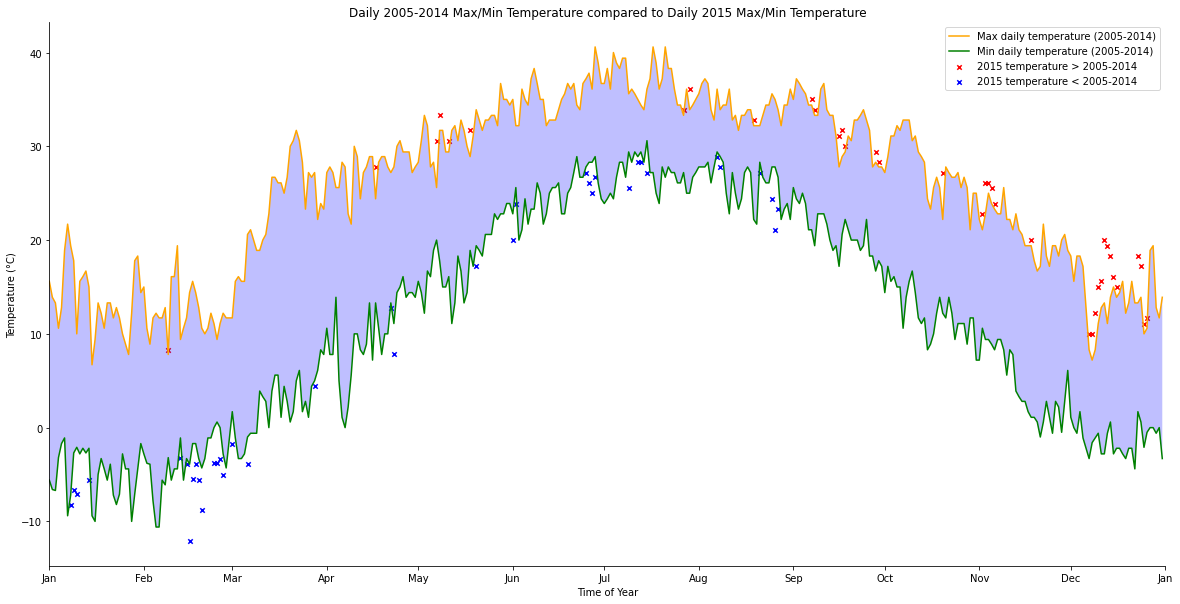

In [29]:
import matplotlib.pyplot as plt
from calendar import month_abbr
import matplotlib.dates as mdates
import datetime

# Create a new figure with specified size
fig = plt.figure(figsize=(20,10))

# Plot maximum and minimum temperatures for 2005-2014
plt.plot(df_DateMAX_05_14.index, df_DateMAX_05_14['Data_Value'], c='orange', label='Max daily temperature (2005-2014)')
plt.plot(df_DateMIN_05_14.index, df_DateMIN_05_14['Data_Value'], c='green', label='Min daily temperature (2005-2014)')

# Scatter plot for temperature records in 2015 that exceed those of 2005-2014
plt.scatter(df_DateMAX_2015_Exceed.index, df_DateMAX_2015_Exceed['Data_Value'], c='red', s = 20, marker='x', label='2015 temperature > 2005-2014')
plt.scatter(df_DateMIN_2015_Exceed.index, df_DateMIN_2015_Exceed['Data_Value'], c='blue', s = 20, marker='x', label='2015 temperature < 2005-2014')

# Define date format for x-axis
monthsFmt = mdates.DateFormatter('%b')

# Add labels to axes and title to the plot
plt.xlabel('Time of Year')  # X-axis label
plt.ylabel('Temperature (Â°C)')  # Y-axis label
plt.title('Daily 2005-2014 Max/Min Temperature compared to Daily 2015 Max/Min Temperature')  # Title of the plot

# Add legend using labels from plt.scatter
plt.legend(loc='upper right')

# Format x-axis to display months
plt.gca().xaxis.set_major_formatter(monthsFmt)

# Set x-axis limits
plt.gca().set_xlim([datetime.date(2024, 1, 1), datetime.date(2025, 1, 1)])

# Fill the area between the maximum and minimum temperature lines
plt.gca().fill_between(df_DateMAX_05_14.index, 
                       df_DateMAX_05_14['Data_Value'], df_DateMIN_05_14['Data_Value'], 
                       facecolor='blue', 
                       alpha=0.25)

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Set major locator for x-axis to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
